In [ ]:
import os
import numpy as np
import pandas as pd
import tensorflow as tf
from sklearn.preprocessing import MinMaxScaler, OneHotEncoder
from sklearn.impute import SimpleImputer
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.metrics import roc_auc_score
import tensorflow as tf
from tqdm import tqdm
from typing import Literal, Callable
import joblib

In [2]:
testPath = r'C:\Users\LENOVO\OneDrive\Desktop\Python\Datasets\isis\test-metadata.csv'
trainPath = r'C:\Users\LENOVO\OneDrive\Desktop\Python\Datasets\isis\train-metadata.csv'

In [88]:
train_data = pd.read_csv(trainPath)
test_data = pd.read_csv(testPath)

C:\Users\LENOVO\AppData\Local\Temp\ipykernel_1752\2039320789.py:1: DtypeWarning: Columns (51,52) have mixed types. Specify dtype option on import or set low_memory=False.
  train_data = pd.read_csv(trainPath)


In [89]:
train_data

,isic_id,target,patient_id,age_approx,sex,anatom_site_general,clin_size_long_diam_mm,image_type,tbp_tile_type,tbp_lv_A,...,lesion_id,iddx_full,iddx_1,iddx_2,iddx_3,iddx_4,iddx_5,mel_mitotic_index,mel_thick_mm,tbp_lv_dnn_lesion_confidence
0,ISIC_0015670,0,IP_1235828,60.0,male,lower extremity,3.04,TBP tile: close-up,3D: white,20.244422,...,NaN,Benign,Benign,NaN,NaN,NaN,NaN,NaN,NaN,97.517282
1,ISIC_0015845,0,IP_8170065,60.0,male,head/neck,1.10,TBP tile: close-up,3D: white,31.712570,...,IL_6727506,Benign,Benign,NaN,NaN,NaN,NaN,NaN,NaN,3.141455
2,ISIC_0015864,0,IP_6724798,60.0,male,posterior torso,3.40,TBP tile: close-up,3D: XP,22.575830,...,NaN,Benign,Benign,NaN,NaN,NaN,NaN,NaN,NaN,99.804040
3,ISIC_0015902,0,IP_4111386,65.0,male,anterior torso,3.22,TBP tile: close-up,3D: XP,14.242329,...,NaN,Benign,Benign,NaN,NaN,NaN,NaN,NaN,NaN,99.989998
4,ISIC_0024200,0,IP_8313778,55.0,male,anterior torso,2.73,TBP tile: close-up,3D: white,24.725520,...,NaN,Benign,Benign,NaN,NaN,NaN,NaN,NaN,NaN,70.442510
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
401054,ISIC_9999937,0,IP_1140263,70.0,male,anterior torso,6.80,TBP tile: close-up,3D: XP,22.574335,...,IL_9520694,Benign,Benign,NaN,NaN,NaN,NaN,NaN,NaN,99.999988
401055,ISIC_9999951,0,IP_5678181,60.0,male,posterior torso,3.11,TBP tile: close-up,3D: white,19.977640,...,NaN,Benign,Benign,NaN,NaN,NaN,NaN,NaN,NaN,99.999820
401056,ISIC_9999960,0,IP_0076153,65.0,female,anterior torso,2.05,TBP tile: close-up,3D: XP,17.332567,...,IL_9852274,Benign,Benign,NaN,NaN,NaN,NaN,NaN,NaN,99.999416
401057,ISIC_9999964,0,IP_5231513,30.0,female,anterior torso,2.80,TBP tile: close-up,3D: XP,22.288570,...,NaN,Benign,Benign,NaN,NaN,NaN,NaN,NaN,NaN,100.000000


In [90]:
train_columns = set(train_data.columns)
test_columns = set(test_data.columns)

difference = train_columns.difference(test_columns)
difference

{'iddx_1',
 'iddx_2',
 'iddx_3',
 'iddx_4',
 'iddx_5',
 'iddx_full',
 'lesion_id',
 'mel_mitotic_index',
 'mel_thick_mm',
 'target',
 'tbp_lv_dnn_lesion_confidence'}

In [91]:
difference.discard('target')
difference

{'iddx_1',
 'iddx_2',
 'iddx_3',
 'iddx_4',
 'iddx_5',
 'iddx_full',
 'lesion_id',
 'mel_mitotic_index',
 'mel_thick_mm',
 'tbp_lv_dnn_lesion_confidence'}

In [92]:
train_copy = train_data.drop(columns=list(difference)).copy()
train_copy

,isic_id,target,patient_id,age_approx,sex,anatom_site_general,clin_size_long_diam_mm,image_type,tbp_tile_type,tbp_lv_A,...,tbp_lv_radial_color_std_max,tbp_lv_stdL,tbp_lv_stdLExt,tbp_lv_symm_2axis,tbp_lv_symm_2axis_angle,tbp_lv_x,tbp_lv_y,tbp_lv_z,attribution,copyright_license
0,ISIC_0015670,0,IP_1235828,60.0,male,lower extremity,3.04,TBP tile: close-up,3D: white,20.244422,...,0.000000,2.036195,2.637780,0.590476,85,-182.703552,613.493652,-42.427948,Memorial Sloan Kettering Cancer Center,CC-BY
1,ISIC_0015845,0,IP_8170065,60.0,male,head/neck,1.10,TBP tile: close-up,3D: white,31.712570,...,0.000000,0.853227,3.912844,0.285714,55,-0.078308,1575.687000,57.174500,Memorial Sloan Kettering Cancer Center,CC-BY
2,ISIC_0015864,0,IP_6724798,60.0,male,posterior torso,3.40,TBP tile: close-up,3D: XP,22.575830,...,0.000000,1.743651,1.950777,0.361905,105,123.649700,1472.010000,232.908900,Memorial Sloan Kettering Cancer Center,CC-BY
3,ISIC_0015902,0,IP_4111386,65.0,male,anterior torso,3.22,TBP tile: close-up,3D: XP,14.242329,...,0.664690,1.258541,1.573733,0.209581,130,-141.024780,1442.185791,58.359802,ACEMID MIA,CC-0
4,ISIC_0024200,0,IP_8313778,55.0,male,anterior torso,2.73,TBP tile: close-up,3D: white,24.725520,...,0.000000,2.085409,2.480509,0.313433,20,-72.315640,1488.720000,21.428960,Memorial Sloan Kettering Cancer Center,CC-BY
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
401054,ISIC_9999937,0,IP_1140263,70.0,male,anterior torso,6.80,TBP tile: close-up,3D: XP,22.574335,...,2.328066,7.054819,2.169398,0.288920,100,147.187256,1182.317505,122.652588,"Department of Dermatology, Hospital Clínic de ...",CC-BY-NC
401055,ISIC_9999951,0,IP_5678181,60.0,male,posterior torso,3.11,TBP tile: close-up,3D: white,19.977640,...,1.048147,1.879502,2.910780,0.460000,25,52.349740,1393.187000,127.261700,Memorial Sloan Kettering Cancer Center,CC-BY
401056,ISIC_9999960,0,IP_0076153,65.0,female,anterior torso,2.05,TBP tile: close-up,3D: XP,17.332567,...,0.607554,1.702824,2.205272,0.183099,40,54.622246,1065.263672,-106.833740,"Frazer Institute, The University of Queensland...",CC-BY
401057,ISIC_9999964,0,IP_5231513,30.0,female,anterior torso,2.80,TBP tile: close-up,3D: XP,22.288570,...,1.078204,3.680175,1.957157,0.161850,140,-9.861557,877.527000,-76.982120,University Hospital of Basel,CC-BY-NC


In [93]:
columns_drop = ['patient_id', 'attribution', 'copyright_license', 'image_type']
train_copy.drop(columns=columns_drop, inplace=True)
test_copy = test_data.copy()
test_copy.drop(columns=columns_drop, inplace=True)

In [9]:
malignant_data = train_copy[train_copy.target == 1]
malignant_data

,isic_id,target,age_approx,sex,anatom_site_general,clin_size_long_diam_mm,tbp_tile_type,tbp_lv_A,tbp_lv_Aext,tbp_lv_B,...,tbp_lv_norm_color,tbp_lv_perimeterMM,tbp_lv_radial_color_std_max,tbp_lv_stdL,tbp_lv_stdLExt,tbp_lv_symm_2axis,tbp_lv_symm_2axis_angle,tbp_lv_x,tbp_lv_y,tbp_lv_z
387,ISIC_0082829,1,80.0,female,anterior torso,9.27,3D: XP,18.093368,13.054772,19.090458,...,9.830578,32.598015,3.514434,5.464301,2.717044,0.472358,0,61.956005,1180.003540,-77.904053
935,ISIC_0096034,1,75.0,male,head/neck,3.88,3D: white,26.187010,21.394010,25.553420,...,1.757932,13.776510,0.549971,1.604156,2.798056,0.576744,15,54.423520,1675.860000,-37.749880
1245,ISIC_0104229,1,80.0,male,anterior torso,6.55,3D: white,33.480140,24.249430,26.160100,...,4.108186,21.453450,1.340916,1.539307,3.697858,0.546485,155,84.834820,1441.758000,-60.321040
1846,ISIC_0119495,1,60.0,male,upper extremity,5.27,3D: white,25.872050,20.194650,26.805590,...,3.850777,20.097350,1.104453,2.575811,2.600541,0.428889,160,293.127500,1425.201000,50.789730
3478,ISIC_0157834,1,55.0,male,posterior torso,5.29,3D: white,30.966662,22.008635,24.066940,...,7.734870,19.128714,2.904396,4.122797,3.134399,0.422091,65,-128.599152,1481.198364,13.294312
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
396165,ISIC_9877311,1,50.0,female,posterior torso,8.16,3D: XP,17.351658,11.348823,23.910937,...,6.918433,22.936795,2.432117,3.608785,1.910770,0.256480,165,-140.668518,1112.529053,96.400574
398671,ISIC_9941636,1,60.0,female,posterior torso,5.65,3D: XP,21.990980,14.083370,34.254300,...,2.577602,17.518120,0.814219,1.041683,1.945723,0.292531,140,63.765810,1252.122000,72.269710
399936,ISIC_9972649,1,60.0,male,lower extremity,8.51,3D: white,19.003400,11.828330,21.741510,...,10.000000,27.032620,4.097754,5.966068,2.845118,0.461798,175,-72.287600,622.391700,82.021270
399943,ISIC_9972877,1,65.0,female,lower extremity,12.08,3D: white,23.465230,18.400280,17.359240,...,6.855612,40.562690,2.283022,3.818278,2.006672,0.163862,20,-102.059400,518.162400,48.836550


In [10]:
X = train_copy.drop(columns=["target", 'isic_id'])  

In [11]:
numericalTransformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='mean')),
    ('scaler', MinMaxScaler())
])

categoricalTransformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='most_frequent')),
    ('encoder', OneHotEncoder(handle_unknown='ignore'))
])

categorical_columns = X.select_dtypes(include=['object','category']).columns
numerical_columns = X.select_dtypes(include=['int64', 'float64']).columns

preprocessor = ColumnTransformer(transformers=[
    ('num', numericalTransformer, numerical_columns),
    ('categorical', categoricalTransformer, categorical_columns)
], remainder='passthrough', sparse_threshold=0.0)

pipeline = Pipeline(steps=[
    ('preprocessor', preprocessor)
])

In [12]:
x = pipeline.fit_transform(X)

In [13]:
x_malignant = pipeline.transform(malignant_data.drop(columns=["target", 'isic_id']))
x_malignant.shape

(393, 72)

In [14]:
def load_and_preprocess_image(path):
    image = tf.io.read_file(path)
    image = tf.image.decode_jpeg(image, channels=3)
    image = tf.image.resize(image, [64, 64])
    image = tf.cast(image, tf.float32)
    return image

In [15]:
def load_image_class(image_dir, ids: set, loading_func : Callable[[any], any], type: Literal['Benign', 'Malignant']):
    images = []

    for path in tqdm(os.listdir(image_dir), desc=f'Loading {type} Images', total=len(list(ids))):
        image_id = path.split('.')[0].strip()
        if image_id in ids:
            image_path = os.path.join(image_dir, path)
            if os.path.exists(image_path):
                image = loading_func(image_path)
                images.append(image)
            else:
                print(f"Image path {image_path} doesn't exist")
    
    return np.array(images)

In [16]:
image_dir = r"C:\Users\LENOVO\Desktop\Python\Datasets\isis\train-image\image"

In [17]:
malignant_id = set(malignant_data.isic_id)

malignant_images = load_image_class(image_dir, malignant_id, load_and_preprocess_image, type='Malignant')

Loading Malignant Images: 401059it [00:00, 418081.79it/s]        


In [18]:
malignant_images.shape

(393, 64, 64, 3)

In [19]:
FILL_MODE = 'nearest'
VALUE_RANGE = [0.0, 1.0]

augment1 = tf.keras.Sequential([
    tf.keras.layers.RandomFlip("horizontal"),
    tf.keras.layers.RandomRotation(0.1, fill_mode=FILL_MODE),
    tf.keras.layers.RandomZoom(0.1),
    tf.keras.layers.RandomContrast(0.1),
])

augment2 = tf.keras.Sequential([
    tf.keras.layers.RandomFlip("vertical"),
    tf.keras.layers.RandomBrightness((-0.5, 0.5), value_range=VALUE_RANGE),
    tf.keras.layers.RandomTranslation((-0.2, 0.3), (-0.3, 0.2), fill_mode=FILL_MODE),
    tf.keras.layers.RandomContrast(0.1),
])

augment3 = tf.keras.Sequential([
    tf.keras.layers.RandomHeight(0.2),
    tf.keras.layers.RandomBrightness((-0.35, 0.35), value_range=VALUE_RANGE),
    tf.keras.layers.RandomRotation(0.3, fill_mode=FILL_MODE),
    tf.keras.layers.Resizing(64, 64),
])

augment4 = tf.keras.Sequential([
    tf.keras.layers.RandomZoom(0.1),
    tf.keras.layers.RandomContrast(0.1),
])

augment5 = tf.keras.Sequential([
    tf.keras.layers.RandomZoom(0.1),
    tf.keras.layers.RandomContrast(0.1),
    tf.keras.layers.RandomBrightness((-0.2, 0.5), value_range=VALUE_RANGE),
])

augment6 = tf.keras.Sequential([
    tf.keras.layers.RandomFlip("horizontal_and_vertical"),
    tf.keras.layers.RandomRotation(0.25, fill_mode=FILL_MODE),
    tf.keras.layers.RandomZoom(0.2),
    tf.keras.layers.RandomContrast(0.2),
    tf.keras.layers.RandomCrop(100, 100),
    tf.keras.layers.Resizing(64, 64),
])

augment7 = tf.keras.Sequential([
    tf.keras.layers.RandomTranslation(0.4, 0.4, fill_mode=FILL_MODE),
    tf.keras.layers.RandomRotation(0.4, fill_mode=FILL_MODE),
    tf.keras.layers.RandomHeight(0.3),
    tf.keras.layers.RandomWidth(0.3),
    tf.keras.layers.RandomBrightness((-0.5, 0.5), value_range=VALUE_RANGE),
    tf.keras.layers.Resizing(64, 64),
])

augment8 = tf.keras.Sequential([
    tf.keras.layers.RandomCrop(100, 100),
    tf.keras.layers.Resizing(64, 64),
    tf.keras.layers.RandomBrightness((-0.3, 0.3), value_range=VALUE_RANGE),
    tf.keras.layers.RandomContrast(0.2),
])

augment9 = tf.keras.Sequential([
    tf.keras.layers.RandomFlip("horizontal"),
    tf.keras.layers.RandomRotation(0.2, fill_mode=FILL_MODE),
    tf.keras.layers.RandomBrightness((-0.4, 0.4), value_range=VALUE_RANGE),
    tf.keras.layers.RandomContrast(0.3),
    tf.keras.layers.RandomZoom((-0.3, 0.3)),
    tf.keras.layers.Resizing(64, 64),
])

augment10 = tf.keras.Sequential([
    tf.keras.layers.RandomFlip("horizontal_and_vertical"),
    tf.keras.layers.RandomTranslation(0.3, 0.3, fill_mode=FILL_MODE),
    tf.keras.layers.RandomRotation(0.5, fill_mode=FILL_MODE),
    tf.keras.layers.RandomZoom(0.3),
    tf.keras.layers.RandomBrightness((-0.6, 0.6), value_range=VALUE_RANGE),
    tf.keras.layers.RandomContrast(0.4),
    tf.keras.layers.RandomCrop(110, 110),
    tf.keras.layers.Resizing(64, 64),
])

augment11 = tf.keras.Sequential([
    tf.keras.layers.RandomFlip("horizontal"),
    tf.keras.layers.RandomBrightness((-0.6, 0.6), value_range=VALUE_RANGE),
    tf.keras.layers.RandomZoom(0.2),
    tf.keras.layers.Resizing(64, 64)
])

augment12 = tf.keras.Sequential([
    tf.keras.layers.RandomRotation(0.4, fill_mode=FILL_MODE),
    tf.keras.layers.RandomWidth(0.3),
    tf.keras.layers.RandomBrightness((-0.3, 0.3), value_range=VALUE_RANGE),
    tf.keras.layers.Resizing(64, 64)
])

augment13 = tf.keras.Sequential([
    tf.keras.layers.RandomHeight(0.2),
    tf.keras.layers.RandomFlip("vertical"),
    tf.keras.layers.RandomContrast(0.3),
    tf.keras.layers.Resizing(64, 64)
])

augment14 = tf.keras.Sequential([
    tf.keras.layers.RandomZoom((-0.2, 0.3)),
    tf.keras.layers.RandomRotation(0.5, fill_mode=FILL_MODE),
    tf.keras.layers.RandomBrightness((-0.2, 0.5), value_range=VALUE_RANGE),
    tf.keras.layers.Resizing(64, 64)
])

augment15 = tf.keras.Sequential([
    tf.keras.layers.RandomCrop(110, 110),
    tf.keras.layers.RandomContrast(0.3),
    tf.keras.layers.RandomZoom(0.2),
    tf.keras.layers.Resizing(64, 64)
])

augment16 = tf.keras.Sequential([
    tf.keras.layers.RandomTranslation(0.25, 0.25, fill_mode=FILL_MODE),
    tf.keras.layers.RandomBrightness((-0.5, 0.4), value_range=VALUE_RANGE),
    tf.keras.layers.RandomFlip("horizontal_and_vertical"),
    tf.keras.layers.Resizing(64, 64)
])

augment17 = tf.keras.Sequential([
    tf.keras.layers.RandomRotation(0.15, fill_mode=FILL_MODE),
    tf.keras.layers.RandomZoom(0.15),
    tf.keras.layers.RandomBrightness((-0.3, 0.3), value_range=VALUE_RANGE),
    tf.keras.layers.RandomHeight(0.2),
    tf.keras.layers.Resizing(64, 64)
])

augment18 = tf.keras.Sequential([
    tf.keras.layers.RandomWidth(0.2),
    tf.keras.layers.RandomBrightness((-0.2, 0.2), value_range=VALUE_RANGE),
    tf.keras.layers.RandomRotation(0.25, fill_mode=FILL_MODE),
    tf.keras.layers.RandomContrast(0.2),
    tf.keras.layers.Resizing(64, 64)
])

augment19 = tf.keras.Sequential([
    tf.keras.layers.RandomZoom(0.3),
    tf.keras.layers.RandomBrightness((-0.3, 0.5), value_range=VALUE_RANGE),
    tf.keras.layers.RandomCrop(100, 100),
    tf.keras.layers.Resizing(64, 64)
])

augment20 = tf.keras.Sequential([
    tf.keras.layers.RandomRotation(0.2, fill_mode=FILL_MODE),
    tf.keras.layers.RandomHeight(0.3),
    tf.keras.layers.RandomTranslation(0.2, 0.2, fill_mode=FILL_MODE),
    tf.keras.layers.Resizing(64, 64)
])

augment21 = tf.keras.Sequential([
    tf.keras.layers.RandomFlip("horizontal"),
    tf.keras.layers.RandomZoom(0.25),
    tf.keras.layers.RandomBrightness((-0.4, 0.4), value_range=VALUE_RANGE),
    tf.keras.layers.Resizing(64, 64)
])

augment22 = tf.keras.Sequential([
    tf.keras.layers.RandomContrast(0.3),
    tf.keras.layers.RandomWidth(0.2),
    tf.keras.layers.RandomCrop(105, 105),
    tf.keras.layers.Resizing(64, 64)
])

augment23 = tf.keras.Sequential([
    tf.keras.layers.RandomFlip("vertical"),
    tf.keras.layers.RandomZoom(0.15),
    tf.keras.layers.RandomBrightness((-0.6, 0.6), value_range=VALUE_RANGE),
    tf.keras.layers.Resizing(64, 64)
])

augment24 = tf.keras.Sequential([
    tf.keras.layers.RandomTranslation(0.3, 0.1, fill_mode=FILL_MODE),
    tf.keras.layers.RandomContrast(0.4),
    tf.keras.layers.RandomRotation(0.35, fill_mode=FILL_MODE),
    tf.keras.layers.Resizing(64, 64)
])

augment25 = tf.keras.Sequential([
    tf.keras.layers.RandomBrightness((-0.5, 0.3), value_range=VALUE_RANGE),
    tf.keras.layers.RandomZoom(0.2),
    tf.keras.layers.RandomFlip("horizontal_and_vertical"),
    tf.keras.layers.Resizing(64, 64)
])

augment26 = tf.keras.Sequential([
    tf.keras.layers.RandomWidth(0.3),
    tf.keras.layers.RandomHeight(0.3),
    tf.keras.layers.RandomBrightness((-0.5, 0.5), value_range=VALUE_RANGE),
    tf.keras.layers.Resizing(64, 64)
])

augment27 = tf.keras.Sequential([
    tf.keras.layers.RandomCrop(108, 108),
    tf.keras.layers.RandomContrast(0.25),
    tf.keras.layers.RandomZoom(0.1),
    tf.keras.layers.Resizing(64, 64)
])

augment28 = tf.keras.Sequential([
    tf.keras.layers.RandomRotation(0.1, fill_mode=FILL_MODE),
    tf.keras.layers.RandomBrightness((-0.4, 0.4), value_range=VALUE_RANGE),
    tf.keras.layers.RandomTranslation(0.4, 0.4, fill_mode=FILL_MODE),
    tf.keras.layers.Resizing(64, 64)
])

augment29 = tf.keras.Sequential([
    tf.keras.layers.RandomFlip("horizontal_and_vertical"),
    tf.keras.layers.RandomZoom(0.1),
    tf.keras.layers.RandomRotation(0.2, fill_mode=FILL_MODE),
    tf.keras.layers.RandomBrightness((-0.2, 0.4), value_range=VALUE_RANGE),
    tf.keras.layers.Resizing(64, 64)
])

augment30 = tf.keras.Sequential([
    tf.keras.layers.RandomBrightness((-0.35, 0.35), value_range=VALUE_RANGE),
    tf.keras.layers.RandomTranslation(0.2, 0.3, fill_mode=FILL_MODE),
    tf.keras.layers.RandomContrast(0.2),
    tf.keras.layers.RandomZoom(0.15),
    tf.keras.layers.Resizing(64, 64)
])

In [20]:
def apply_all_augmentations(images, tabular_data, augmentations):
    """
    Apply augmentations to the image array and replicate tabular data accordingly.

    Args:
        images (np.ndarray): Shape (N, H, W, C)
        tabular_data (np.ndarray): Shape (N, T)
        augmentations (list): List of Keras preprocessing layers

    Returns:
        tf.data.Dataset: ((image, tabular_data), label)
                         where image shape = (N*K, H, W, C)
                               tabular shape = (N*K, T)
                               labels shape = (N*K,)
    """
    images_tf = tf.convert_to_tensor(images, dtype=tf.float16)
    tabular_tf = tf.convert_to_tensor(tabular_data, dtype=tf.float16)

    augmented_image_batches = []
    replicated_tabular_batches = []

    augmented_image_batches.append(images)
    replicated_tabular_batches.append(tabular_data)

    for aug in tqdm(augmentations, desc='Applying augmentations', total=len(augmentations)):
        augmented_images = aug(images_tf, training=True)
        augmented_image_batches.append(augmented_images)
        replicated_tabular_batches.append(tabular_tf)  

    # Concatenate along the batch axis
    all_augmented_images = tf.concat(augmented_image_batches, axis=0)
    all_replicated_tabular = tf.concat(replicated_tabular_batches, axis=0)

    labels = tf.ones((all_augmented_images.shape[0],), dtype=tf.float16)

    # Final tf.data.Dataset
    return tf.data.Dataset.from_tensor_slices(((all_augmented_images, all_replicated_tabular), labels))


In [21]:
augmentations = [
    augment1, augment2, augment3, augment4, augment5,
    augment6, augment7, augment8, augment9, augment10,
    augment11, augment12, augment13, augment14, augment15,
    augment16, augment17, augment18, augment19, augment20,
    augment21, augment22, augment23, augment24, augment25,
    augment26, augment27, augment28, augment29, augment30
]

malignant = apply_all_augmentations(malignant_images, x_malignant, augmentations)

Applying augmentations:   0%|          | 0/30 [00:00<?, ?it/s]

Applying augmentations: 100%|██████████| 30/30 [00:01<00:00, 17.61it/s]


In [22]:
malignant

<_TensorSliceDataset element_spec=((TensorSpec(shape=(64, 64, 3), dtype=tf.float32, name=None), TensorSpec(shape=(72,), dtype=tf.float16, name=None)), TensorSpec(shape=(), dtype=tf.float16, name=None))>

In [23]:
benign_data = train_copy[train_copy.target == 0].sample(n=12183, replace=False, random_state=69)
benign_data

,isic_id,target,age_approx,sex,anatom_site_general,clin_size_long_diam_mm,tbp_tile_type,tbp_lv_A,tbp_lv_Aext,tbp_lv_B,...,tbp_lv_norm_color,tbp_lv_perimeterMM,tbp_lv_radial_color_std_max,tbp_lv_stdL,tbp_lv_stdLExt,tbp_lv_symm_2axis,tbp_lv_symm_2axis_angle,tbp_lv_x,tbp_lv_y,tbp_lv_z
391450,ISIC_9757206,0,60.0,male,posterior torso,2.73,3D: XP,16.523590,12.631780,25.201060,...,0.000000,8.886309,0.000000,1.729191,2.094512,0.621849,20,11.971850,1470.285000,137.479900
355127,ISIC_8866654,0,50.0,male,posterior torso,3.00,3D: XP,16.672360,12.288180,25.713350,...,2.025579,9.033031,0.519633,2.456064,3.011081,0.301471,60,29.302420,1342.827000,157.044100
177303,ISIC_4470870,0,70.0,male,posterior torso,7.57,3D: white,20.115750,17.153706,26.991859,...,8.157537,24.627636,2.797685,5.000520,2.722402,0.392857,15,-109.535431,1393.000610,187.950378
111841,ISIC_2844615,0,60.0,male,posterior torso,3.88,3D: white,21.029997,18.613355,26.693478,...,3.726808,12.079968,1.421591,1.900086,2.715808,0.554502,80,40.363293,1516.259521,210.784241
239552,ISIC_6020398,0,65.0,NaN,posterior torso,3.30,3D: XP,23.070780,20.793870,27.728400,...,6.465359,10.823590,2.125540,5.686193,1.723505,0.347826,100,-36.170980,1460.184000,165.466600
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
161492,ISIC_4077030,0,55.0,NaN,anterior torso,3.00,3D: XP,14.541630,9.623976,33.628700,...,2.890157,9.340242,1.048844,1.923797,1.639338,0.225166,45,-72.468890,1344.832000,-101.638400
13363,ISIC_0401955,0,85.0,male,upper extremity,4.29,3D: XP,13.388010,7.578369,20.993090,...,5.233969,13.034840,1.273541,5.447674,3.182925,0.244604,60,-313.872500,1320.181000,61.217650
187546,ISIC_4723606,0,65.0,male,upper extremity,3.97,3D: XP,17.706420,13.891870,23.921520,...,2.344779,13.048610,0.782835,1.312136,1.813876,0.170347,115,373.135700,1301.972000,94.442290
53103,ISIC_1383721,0,85.0,male,posterior torso,3.40,3D: XP,23.082105,17.239721,36.214618,...,2.004030,9.354010,0.577312,1.014383,2.219175,0.326667,100,9.292908,1220.638306,156.579529


In [24]:
benign_id = set(benign_data.isic_id)
benign_images = load_image_class(image_dir, benign_id, load_and_preprocess_image, type='Benign')

Loading Benign Images: 401059it [02:37, 2551.89it/s]                          


In [25]:
benign_images.shape

(12183, 64, 64, 3)

In [26]:
x_benign = pipeline.transform(benign_data.drop(columns=['target', 'isic_id']))
print(x_benign.shape)

labels = tf.zeros((benign_images.shape[0],), dtype=tf.float16)

benign = tf.data.Dataset.from_tensor_slices(((benign_images, x_benign), labels)).map(lambda x, y: ((tf.cast(x[0], dtype=tf.float32), tf.cast(x[1], dtype=tf.float16)), y))

(12183, 72)


In [27]:
benign

<_MapDataset element_spec=((TensorSpec(shape=(64, 64, 3), dtype=tf.float32, name=None), TensorSpec(shape=(72,), dtype=tf.float16, name=None)), TensorSpec(shape=(), dtype=tf.float16, name=None))>

In [28]:
combined = benign.concatenate(malignant).shuffle(24366).shuffle(12183)

train_split = int((24366)*0.8)
data_list = list(combined.as_numpy_iterator())
train_list = data_list[:int(0.8 * len(data_list))]
val_list   = data_list[int(0.8 * len(data_list)):]

train_data = tf.data.Dataset.from_generator(lambda: (x for x in train_list),
                                            output_signature=(
                                                (tf.TensorSpec(shape=(64, 64, 3), dtype=tf.float16),
                                                 tf.TensorSpec(shape=(72,), dtype=tf.float16)),
                                                tf.TensorSpec(shape=(), dtype=tf.float16)
                                            )).shuffle(train_split).batch(32).prefetch(tf.data.AUTOTUNE)

val_data = tf.data.Dataset.from_generator(lambda: (x for x in val_list),
                                          output_signature=(
                                              (tf.TensorSpec(shape=(64, 64, 3), dtype=tf.float16),
                                               tf.TensorSpec(shape=(72,), dtype=tf.float16)),
                                              tf.TensorSpec(shape=(), dtype=tf.float16)
                                          )).batch(32).prefetch(tf.data.AUTOTUNE)

In [29]:
train_data

<_PrefetchDataset element_spec=((TensorSpec(shape=(None, 64, 64, 3), dtype=tf.float16, name=None), TensorSpec(shape=(None, 72), dtype=tf.float16, name=None)), TensorSpec(shape=(None,), dtype=tf.float16, name=None))>

In [30]:
y_val = []

for (i, j), k in val_data.unbatch():
    y_val.append(k)

print(np.array(y_val).shape)

y_val = [y.numpy() for y in y_val]

(4874,)


In [ ]:
def partial_auc_score(y_true, y_pred):
    y_true = np.array(y_true)
    y_pred = np.array(y_pred)
    
    min_tpr = 0.80
    max_fpr = abs(1 - min_tpr)

    v_gt = np.abs(y_true - 1)
    v_pred = 1.0 - y_pred

    try:
        partial_auc_scaled = roc_auc_score(v_gt, v_pred, max_fpr=max_fpr)
    except ValueError:
        return 0.0

    # Normalize partial AUC to match full AUC scale (optional but common)
    partial_auc = 0.5 * max_fpr**2 + ((max_fpr - 0.5 * max_fpr**2) / 0.5) * (partial_auc_scaled - 0.5)
    
    return partial_auc

In [31]:
def build_dynamic_model(trial):
    # ========== IMAGE BRANCH ==========
    img_input = tf.keras.Input(shape=(64, 64, 3), name='img_input')
    x = img_input

    num_conv_blocks = trial.suggest_int('num_conv_blocks', 2, 4)
    for i in range(num_conv_blocks):
        filters = trial.suggest_categorical(f'filters_block_{i}', [32, 64, 128, 256])
        x = tf.keras.layers.Conv2D(filters, (3, 3), activation='relu', padding='same')(x)
        x = tf.keras.layers.BatchNormalization()(x)
        x = tf.keras.layers.MaxPooling2D((2, 2))(x)

    x = tf.keras.layers.Flatten()(x)

    # ========== TABULAR BRANCH ==========
    tab_input = tf.keras.Input(shape=(72,), name='tabular_input')
    y = tab_input

    num_tab_dense = trial.suggest_int('num_tab_dense', 1, 3)
    for i in range(num_tab_dense):
        units = trial.suggest_categorical(f'tab_dense_units_{i}', [32, 64, 128])
        y = tf.keras.layers.Dense(units, activation='relu',
                                  kernel_regularizer=tf.keras.regularizers.L2(trial.suggest_float('tab_l2', 1e-6, 1e-3)))(y)
        y = tf.keras.layers.Dropout(trial.suggest_float(f'tab_dropout_{i}', 0.1, 0.4))(y)

    # ========== MERGING BRANCH ==========
    merged = tf.keras.layers.concatenate([x, y])

    num_merge_dense = trial.suggest_int('num_merge_dense', 1, 3)
    z = merged
    for i in range(num_merge_dense):
        units = trial.suggest_categorical(f'merge_dense_units_{i}', [64, 128, 256])
        z = tf.keras.layers.Dense(units, activation='relu')(z)
        z = tf.keras.layers.Dropout(trial.suggest_float(f'merge_dropout_{i}', 0.2, 0.5))(z)

    output = tf.keras.layers.Dense(1, activation='sigmoid')(z)

    model = tf.keras.Model(inputs=[img_input, tab_input], outputs=output)

    return model

In [37]:
def objective(trial):
    model = build_dynamic_model(trial)

    lr = trial.suggest_float('lr', 1e-5, 1e-3, log=True)

    model.compile(
        optimizer=tf.keras.optimizers.Adam(learning_rate=lr),
        loss='binary_crossentropy',
        metrics=[tf.keras.metrics.Recall()]
    )

    model.fit(
        train_data.repeat(),
        validation_data=val_data.repeat(),
        epochs=8,
        steps_per_epoch=64,
        validation_steps=16,
        verbose=0
    )

    preds = model.predict(val_data, verbose=0)

    return partial_auc_score(y_val, preds)

In [38]:
import optuna

study = optuna.create_study(direction='maximize')
study.optimize(objective, n_trials=15)

print("Best trial architecture:")
print(study.best_trial.params)

[I 2025-06-07 14:39:44,900] A new study created in memory with name: no-name-7f103282-bb83-4e3e-af75-4219534825ce
c:\Users\LENOVO\AppData\Local\Programs\Python\Python311\Lib\site-packages\keras\src\trainers\epoch_iterator.py:151: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self._interrupted_warning()
[I 2025-06-07 14:42:25,962] Trial 0 finished with value: 0.16056905479767591 and parameters: {'num_conv_blocks': 4, 'filters_block_0': 64, 'filters_block_1': 64, 'filters_block_2': 64, 'filters_block_3': 256, 'num_tab_dense': 2, 'tab_dense_units_0': 32, 'tab_l2': 0.0002516558026681835, 'tab_dropout_0': 0.37264788518335856, 'tab_dense_units_1': 32, 'tab_dropout_1': 0.2532528424887144, 'num_merge_dense': 3, 'merge_dense_units_0': 64, 'merge_dropout_0': 0.4938397849921025, 'merge_dense_units_1': 256, '

Best trial architecture:
{'num_conv_blocks': 2, 'filters_block_0': 128, 'filters_block_1': 256, 'num_tab_dense': 2, 'tab_dense_units_0': 64, 'tab_l2': 0.0007482411093905298, 'tab_dropout_0': 0.20014469873706214, 'tab_dense_units_1': 128, 'tab_dropout_1': 0.20248206465992152, 'num_merge_dense': 1, 'merge_dense_units_0': 256, 'merge_dropout_0': 0.2651704642314885, 'lr': 1.7025833848123752e-05}


In [39]:
img_input = tf.keras.layers.Input(shape=(64, 64, 3), name='img_input')

x = tf.keras.layers.Conv2D(128, (3, 3), activation='relu', padding='same')(img_input)
x = tf.keras.layers.BatchNormalization()(x)
x = tf.keras.layers.MaxPooling2D((2, 2))(x)

x = tf.keras.layers.Conv2D(256, (3, 3), activation='relu', padding='same')(x)
x = tf.keras.layers.BatchNormalization()(x)
x = tf.keras.layers.MaxPooling2D((2, 2))(x)

x = tf.keras.layers.Flatten()(x)

tab_input = tf.keras.layers.Input(shape=(72,), name='tabular_input')
y = tf.keras.layers.Dense(64, activation='relu', kernel_regularizer=tf.keras.regularizers.L2(0.0007482411093905298))(tab_input)
y = tf.keras.layers.Dropout(0.20014469873706214)(y)
y = tf.keras.layers.Dense(128, activation='relu')(y)
y = tf.keras.layers.Dropout(0.20248206465992152)(y)

merged = tf.keras.layers.concatenate([x, y])

z = tf.keras.layers.Dense(256, activation='relu')(merged)
z = tf.keras.layers.Dropout(0.2651704642314885)(z)
output = tf.keras.layers.Dense(1, activation='linear')(z)

model = tf.keras.Model(inputs=[img_input, tab_input], outputs=output)

In [40]:
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=1.7025833848123752e-05),
              loss=tf.keras.losses.BinaryCrossentropy(from_logits=True),
              metrics=['accuracy', 'precision', 'recall'])

model.summary()

Model: "functional_46"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ img_input           │ (None, 64, 64, 3) │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_47 (Conv2D)  │ (None, 64, 64,    │      3,584 │ img_input[0][0]   │
│                     │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 64, 64,    │        512 │ conv2d_47[0][0]   │
│ (BatchNormalizatio… │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_47    │ (None, 32, 32,    │          0 │ batch_normalizat… │
│ (MaxPooling2D)      │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ tabular_input       │ (None, 72)        │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_48 (Conv2D)  │ (None, 32, 32,    │    295,168 │ max_pooling2d_47… │
│                     │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_76 (Dense)    │ (None, 64)        │      4,672 │ tabular_input[0]… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 32, 32,    │      1,024 │ conv2d_48[0][0]   │
│ (BatchNormalizatio… │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_60          │ (None, 64)        │          0 │ dense_76[0][0]    │
│ (Dropout)           │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_48    │ (None, 16, 16,    │          0 │ batch_normalizat… │
│ (MaxPooling2D)      │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_77 (Dense)    │ (None, 128)       │      8,320 │ dropout_60[0][0]  │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ flatten_16          │ (None, 65536)     │          0 │ max_pooling2d_48… │
│ (Flatten)           │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_61          │ (None, 128)       │          0 │ dense_77[0][0]    │
│ (Dropout)           │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ concatenate_16      │ (None, 65664)     │          0 │ flatten_16[0][0], │
│ (Concatenate)       │                   │            │ dropout_61[0][0]  │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_78 (Dense)    │ (None, 256)       │ 16,810,240 │ concatenate_16[0… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_62          │ (None, 256)       │          0 │ dense_78[0][0]    │
│ (Dropout)           │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_79 (Dense)    │ (None, 1)         │        257 │ dropout_62[0][0]  │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 17,123,777 (65.32 MB)

 Trainable params: 17,123,009 (65.32 MB)

 Non-trainable params: 768 (3.00 KB)

In [41]:
callbacks = [tf.keras.callbacks.EarlyStopping(patience=4, monitor='val_recall'), tf.keras.callbacks.ReduceLROnPlateau(monitor='val_recall', factor=0.5, patience=2)]

model.fit(train_data.repeat(),
          validation_data=val_data.repeat(),
          epochs=10,
          steps_per_epoch=64,
          validation_steps=32,
          callbacks=callbacks)

Epoch 1/10
64/64 ━━━━━━━━━━━━━━━━━━━━ 34s 387ms/step - accuracy: 0.8315 - loss: 0.5281 - precision: 0.8769 - recall: 0.7666 - val_accuracy: 0.8877 - val_loss: 0.3170 - val_precision: 0.9683 - val_recall: 0.7956 - learning_rate: 1.7026e-05
Epoch 2/10
64/64 ━━━━━━━━━━━━━━━━━━━━ 27s 426ms/step - accuracy: 0.9065 - loss: 0.3026 - precision: 0.9519 - recall: 0.8539 - val_accuracy: 0.9072 - val_loss: 0.2928 - val_precision: 0.9489 - val_recall: 0.8557 - learning_rate: 1.7026e-05
Epoch 3/10
64/64 ━━━━━━━━━━━━━━━━━━━━ 30s 464ms/step - accuracy: 0.8933 - loss: 0.3158 - precision: 0.9512 - recall: 0.8232 - val_accuracy: 0.9160 - val_loss: 0.2537 - val_precision: 0.9836 - val_recall: 0.8417 - learning_rate: 1.7026e-05
Epoch 4/10
64/64 ━━━━━━━━━━━━━━━━━━━━ 31s 483ms/step - accuracy: 0.9031 - loss: 0.2740 - precision: 0.9610 - recall: 0.8430 - val_accuracy: 0.9238 - val_loss: 0.2307 - val_precision: 0.9730 - val_recall: 0.8677 - learning_rate: 8.5129e-06
Epoch 5/10
64/64 ━━━━━━━━━━━━━━━━━━━━ 31s 48

In [42]:
import matplotlib.pyplot as plt

def plot(p1, p2, title, legend, ylabel, xlabel = 'epochs'):
    plt.plot(p1)
    plt.plot(p2)
    plt.title(title)
    plt.legend(legend)
    plt.xlabel(xlabel)
    plt.ylabel(ylabel)

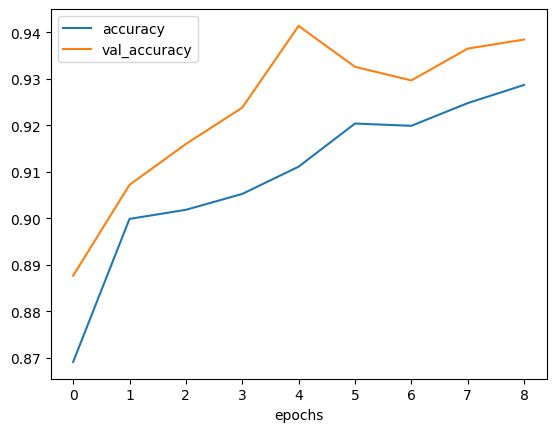

In [43]:
plot(model.history.history['accuracy'], model.history.history['val_accuracy'], title=None, legend=['accuracy', 'val_accuracy'], ylabel=None)

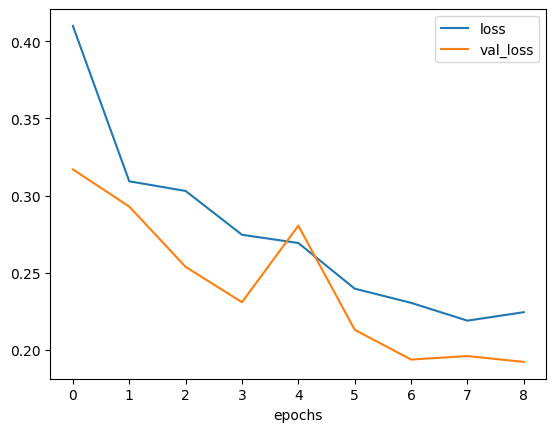

In [44]:
plot(model.history.history['loss'], model.history.history['val_loss'], title=None, legend=['loss', 'val_loss'], ylabel=None)

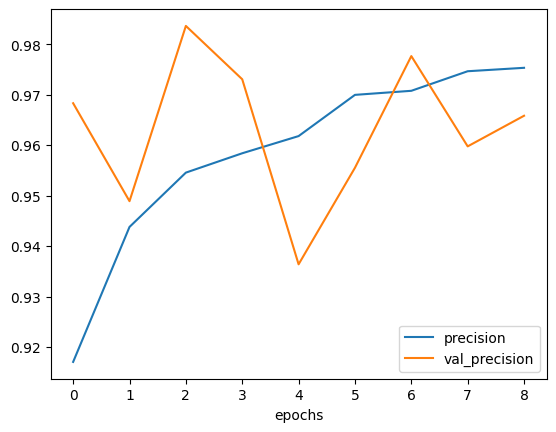

In [45]:
plot(model.history.history['precision'], model.history.history['val_precision'], title=None, legend=['precision', 'val_precision'], ylabel=None)

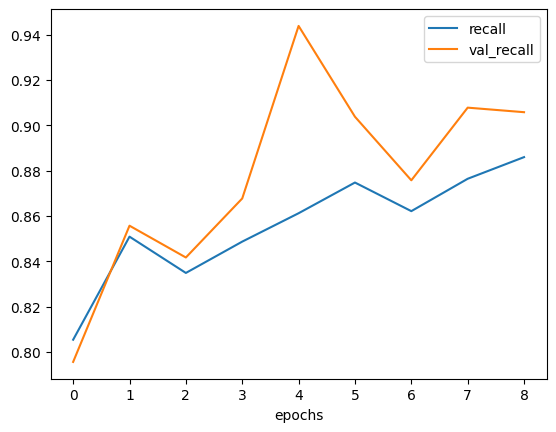

In [46]:
plot(model.history.history['recall'], model.history.history['val_recall'], title=None, legend=['recall', 'val_recall'], ylabel=None)

In [53]:
test_copy

,isic_id,age_approx,sex,anatom_site_general,clin_size_long_diam_mm,tbp_tile_type,tbp_lv_A,tbp_lv_Aext,tbp_lv_B,tbp_lv_Bext,...,tbp_lv_norm_color,tbp_lv_perimeterMM,tbp_lv_radial_color_std_max,tbp_lv_stdL,tbp_lv_stdLExt,tbp_lv_symm_2axis,tbp_lv_symm_2axis_angle,tbp_lv_x,tbp_lv_y,tbp_lv_z
0,ISIC_0015657,45.0,male,posterior torso,2.70,3D: XP,22.80433,20.007270,28.38412,27.043640,...,1.143374,9.387248,0.304827,1.281532,2.299935,0.479339,20,-155.06510,1511.222000,113.980100
1,ISIC_0015729,35.0,female,lower extremity,2.52,3D: XP,16.64867,9.657964,31.31752,27.524318,...,0.000000,6.340311,0.000000,1.271940,2.011223,0.426230,25,-112.36924,629.535889,-15.019287
2,ISIC_0015740,65.0,male,posterior torso,3.16,3D: XP,24.25384,19.937380,30.46368,28.384240,...,0.721739,8.130868,0.230742,1.080308,2.705857,0.366071,110,-84.29282,1303.978000,-28.576050


In [103]:
test_images = []
test_path = r'C:\Users\LENOVO\Desktop\Python\Datasets\isis\test-image'

for path in os.listdir(test_path):
    img_path = os.path.join(test_path, path)
    test_images.append(load_and_preprocess_image(img_path))

extra_row = train_copy[train_copy.isic_id == 'ISIC_0104229'].drop(columns=['isic_id', 'target'])
combined_tab = pd.concat([
    test_copy.drop(columns=['isic_id']),
    extra_row
], ignore_index=True)

test_tab = pipeline.transform(combined_tab)

In [104]:
img = load_and_preprocess_image(r'C:\Users\LENOVO\Desktop\Python\Datasets\isis\malignant_images\ISIC_0104229.jpg')

In [105]:
test_images.append(img)

In [107]:
test_tab.shape

(4, 72)

In [109]:
test_images = np.array(test_images).reshape((-1, 64, 64, 3))
test_images.shape

(4, 64, 64, 3)

In [110]:
predictions = model.predict((test_images, test_tab))

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 146ms/step


In [111]:
proba = 1/(1 + np.exp(-predictions))
proba

array([[0.0203547 ],
       [0.17486055],
       [0.01257642],
       [0.9870996 ]], dtype=float32)

In [ ]:
model.save('MultiModal.keras')
joblib.dump(pipeline, 'MultiModal-Pipeline.joblib')

['MultiModal-Pipeline.joblib']